<b> How-to Guide Series </b>

# Access remote assets via API endpoint bridges

Estimated reading time: 20'

## Intro: Accessing remote assets

Welcome to our guide on accessing remote assets through API endpoint bridges. 

If your data resides in the cloud or on an internal platform with an exposed API, you might encounter challenges and inefficiencies when moving or copying data to a PySyft Datasite.

This tutorial will demonstrate how to leverage datasets stored in external data warehouses or platforms — like those provided by various cloud services — to facilitate access for external researchers via PySyft. By using API endpoint bridges, we'll show you how to enable a more controlled and efficient flow of information, offering an advantageous alternative to direct API access.

This approach not only streamlines data access, but also enhances security of your data and ensures compliance.

## How does it work?

<font size="+1">First, how can PySyft work with remote assets?</font>

PySyft allows an admin to define [custom API endpoints](../components/custom-endpoints) that extend the capabilities of their PySyft Datasite and which can be seamlessly used by researchers through the Python `syft` client itself.

These endpoints act as a *bridge to an external service*, such as a cloud platform where data is being stored, as long as they exposes an API that our server can communicate with.

Defining such an endpoint can be done as:

```python
MY_API_KEY="*****"

@sy.api_endpoint(
    path="my_org.query",
    description="This is an example endpoint.",
    settings={"key": MY_API_KEY}
)
def execute_query(
    context,
    query: str,
) -> Any:
    aws_client = ...
    result = aws_client(query)
    ... # apply post-processing, error handling

    return processed_result
```

This means a researcher can access this endpoint via their client and even use it as part of their `syft` functions:

```python
ds_client.api.services.my_org.execute_query(query="SELECT * from table limit 10")
```

Such API bridges allow researchers to access external APIs belonging to organization owning the data, via PySyft

*"But now?"*, you might ask.

<font size="+1">How to enable responsible access to such external APIs?</font>

In previous tutorials, we learned about the concept of *mock* and *private* data: core components of a `sy.Asset` which enables access to data hosted on a PySyft Datasite.

```{admonition} Reminder about mock & private data
A *mock* dataset can be distributed in an open-access fashion since it is fictious, does not contain any private information about individuals, nor any data we would not like to release. It helps inform the researcher on the projects they could conduct and provides a sandbox for coding and testing. In contrast, *private* data is ***never*** directly accessible by external researchers and can only be released through explicit approval.
```

Working with remote assets is surprisingly similar! This is possible using a `TwinAPIEndpoint` which requires defining two separate API endpoints: 
- *Mock*: an endpoint that communicates with an external API hosting mock data with same schema and similar fields as the real data
- *Private*: an endpoint that communicates with an external API that hosts the actual private data.



![Twin API Endpoint](https://om-assets-h3f2axhubqdkbreg.z01.azurefd.net/docs-assets/howto-api-endpoints-twinapiendpoint.png)

A few examples of services you can connect using a `TwinAPIEndpoint`:
- Google BigQuery/BigTable
- Amazon Redshift
- Microsoft Azure SQL Database 

Today we will work with a fictious scenario. Let's assume there is a cloud platform called Nimbus which has a fully managed SQL database in which we are hosting the data, called NimbusDB. Additionally, we assume this platform offers an off-the-shelf Python client, which we mock below:

In [5]:
class NimbusDBClient:
    def __init__(self, api_key, endpoint):
        self.api_key = api_key
        self.endpoint = endpoint
        # print(f"Initialized NimbusDBClient with endpoint {self.endpoint}")

    def connect(self):
        """ Simulate connecting to NimbusDB """
        # Simulate a connection setup
        self.connection_status = "Connected"

    def execute_query(self, query):
        """ Simulate executing a SQL query """
        if self.connection_status == "Connected":
            print(f"Executing query: {query}")
            # Mock result based on query
            if "SELECT" in query:
                return [{'id': 1, 'name': 'Alice'}, {'id': 2, 'name': 'Bob'}]
            elif "UPDATE" in query or "INSERT" in query:
                return "Error: Query executed successfully."
            else:
                return "Error: Unsupported query type."
        else:
            return "Error: Not connected to database."
    
    def get_schema(self, table=""):
        """ Simulate fetching the schema of the SQL table."""
        if self.connection_status == "Connected":
            import pandas as pd

            print(f"Fetching table metadata: {table}")
            return pd.DataFrame.from_dict({
                'field_name': ['id', 'session_id', 'name', '...'],
                'field_type': ['int', 'int', 'str', '...']
            })
        else:
            return "Error: Not connected to database."


# Usage
api_key = "your_api_key_here"
endpoint = "https://api.nimbusdb.com"

# Create a client instance
client = NimbusDBClient(api_key, endpoint)

# Connect to NimbusDB
client.connect()

# Execute a query
result = client.execute_query("SELECT * FROM users")
print("Query Result:", result)


# Execute a query
result = client.get_schema(table="users")
print("Table Scehma Result:", result)

Executing query: SELECT * FROM users
Query Result: [{'id': 1, 'name': 'Alice'}, {'id': 2, 'name': 'Bob'}]
Fetching table metadata: users
Table Scehma Result:    field_name field_type
0          id        int
1  session_id        int
2        name        str
3         ...        ...


If you are a data scientist trying to use such a system, you can read more in-depth about how to access custom API endpoints and use them in [this component guide](../components/custom-endpoints) or jump all the way to the data scientist section below for an example.

## |:data_scientist:| 1. Data Owner: Defining API endpoints

There are a two types of API endpoints, which might suit different needs:
- [Twin Endpoint](../components/custom-endpoints#twin-api-endpoint) - for working with private assets, requiring both a mock and private counterpart
- [Public Endpoint](../components/custom-endpoints#public-api-endpoint) - for working with information that does not require approval - such as metadata

To illustrate how to define each, we will first setup an in-memory node.

In [8]:
import syft as sy

datasite = sy.orchestra.launch(
    name="test-datasite",
    dev_mode=False,
    create_producer=True,
    n_consumers=1,
    reset=True,
    port="auto",
)

client = datasite.login(email="info@openmined.org", password="changethis")
client.register(
    email="user@openmined.org",
    password="verysecurepassword",
    password_verify="verysecurepassword",
    name="New User",
)

ds_client = datasite.login(email="user@openmined.org", password="verysecurepassword")

Starting test-datasite server on 0.0.0.0:54055
Waiting for server to start Done.


SyftInfo: You have launched a development server at http://0.0.0.0:54055.It is intended only for local use.

Logged into <test-datasite: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <test-datasite: High side Datasite> as <user@openmined.org>


### Public API endpoints

A public API endpoint can be freely accessed without the admin's/data owner's approval. A good example of where this is useful while working with remote assets is fetching useful metadata from the platform, such as the table schema.

To achieve this, we rely on the [`context.settings`](../components/custom-endpoints#context-manager) object to pass relevant information to the endpoint, such as the API key, without exposing it.

In [26]:
import pandas as pd
from syft import SyftError
        
MY_API_KEY = "*****"
ENDPOINT = "https://api.nimbusdb.com"

# Define a single, public API Endpoint
@sy.api_endpoint(
    path="nimbusdb.schema",
    description="""
    ## Description
    Allows to get the schema of a table to NimbusDB, a fully managed SQL db in Nimbus.
    
    ## Available tables
    - users
    - sessions
    - content
    - ...

    ## How to use
    Run `<client>.api.services.nimbusdb.schema(table="users")`
    """,
    settings={"key": MY_API_KEY, "endpoint": ENDPOINT}
)
def get_schema(
    context,
    table: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.get_schema(table=table)
    if not isinstance(result, pd.DataFrame):
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(message="An error occured. Please check your query and contact the admin if it persists.")

    return pd.DataFrame(result)

# Add it to the node
response = client.custom_api.add(endpoint=get_schema)
response

SyftSuccess: Endpoint successfully created.

```{warning} Using third-party libs:
It is likely that setting up an API endpoint bridge requires using third-party Python packages. In this case, it's the responsability of the admin to define a custom Docker image that contains such dependencies and launch a worker pool that runs the image. Once that is done, you can bind an endpoint to a custom worker pool. 
```
<!-- More information on [how to set this up available here](../components/custom-endpoints#using-third-party-libraries). -->

In [27]:
# We check the list of custom API endpoints.
client.custom_api.api_endpoints()

[syft.service.api.api.TwinAPIEndpointView]

In [28]:
client.api.services.nimbusdb.schema

## API: nimbusdb.schema
### Description: <span style="font-weight: lighter;">
    ## Description
    Allows to get the schema of a table to NimbusDB, a fully managed SQL db in Nimbus.
    
    ## Available tables
    - users
    - sessions
    - content
    - ...

    ## How to use
    Run `.api.services.nimbusdb.schema(table="users")`
    </span><br>
#### Private Code:
```python
N / A
```
#### Public Code:
```python
def get_schema(
    context,
    table: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.get_schema(table=table)
    if not isinstance(result, pd.DataFrame):
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(message="An error occured. Please check your query and contact the admin if it persists.")

    return pd.DataFrame(result)

```


In [29]:
# Test the endpoint works
client.api.services.nimbusdb.schema(table="users")

Fetching table metadata: users


Pointer:
   field_name field_type
0          id        int
1  session_id        int
2        name        str
3         ...        ...

Now, let's see how to define a `TwinAPIEndpoint`.

### Twin API Endpoints

These are ideal for working with data or model assets, as they enable defining a mocking behaviour and private access, thus allowing data scientists to inform, prototype and submit their analysis without accessing any private information, similar to how PySyft-hosted assets are used.

Now, let's define a `TwinAPIEndpoint` for querying data. This can be achieved in multiple ways, for example:
- Option 1: The mock query returns a hardcoded/orchestrated answer 
- Option 2: The mock query pulls data from an identical setup as the private one, but which contains mock data.

Let's assume, for now, that we are using option 2 and we have set two NimbusDB instances (a mock one and a private one) which are accesible at different endpoints, using different access keys.

In [30]:
MY_MOCK_API_KEY = "*****"
MOCK_ENPOINT = "https://mock.api.nimbusdb.com"

# Define the mock counterpart
@sy.api_endpoint_method(
    settings={"key": MY_MOCK_API_KEY, 
              "endpoint": MOCK_ENPOINT},
)
def public_endpoint_method(
    context,
    query: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.execute_query(query)
    if result == "Error: Unsupported query type.":
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(
            message="An error occured. Please check your query and contact the admin if it persists."
        )


    return pd.DataFrame(result)


MY_API_KEY = "9fhe3ss..."
ENPOINT = "https://api.nimbusdb.com"

# Define the private counterpart
@sy.api_endpoint_method(
    settings={"key": MY_API_KEY, 
              "endpoint": ENPOINT},
)
def private_endpoint_method(
    context,
    query: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.execute_query(query)
    
    if result == "Error: Unsupported query type.":
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(
            message="An error occured. Please check your query and contact the admin if it persists."
        )

    return pd.DataFrame(result)

new_endpoint = sy.TwinAPIEndpoint(
    path="nimbusdb.query",
    mock_function=public_endpoint_method,
    private_function=private_endpoint_method,
    description="Allows to query to NimbusDB, a fully managed SQL db in Nimbus.",
)

# Add it to the node.
response = client.custom_api.add(endpoint=new_endpoint)
response

SyftSuccess: Endpoint successfully created.

At this point, all users who have access to the Datasite can see these endpoints and even choose to run their mock and private versions as below:

```{note} Accessing the private version
Only the admin and data owners can run the private version of the endpoint without approval.
```

Let's test it!

In [32]:
client.api.services.nimbusdb.query.mock(query="SELECT 1")

Executing query: SELECT 1


Pointer:
   id   name
0   1  Alice
1   2    Bob

In [34]:
client.api.services.nimbusdb.query.private(query="WRONG 10")

Executing query: WRONG 10
SyftError: Error: Unsupported query type.
SyftError: Error: Unsupported query type.
SyftError: Error: Unsupported query type.


SyftError: Error: Unsupported query type.

```{warning} What if my API endpoint crashes?
When the execution of an API endpoint fails and results in an exception, the data scientist is unable to view the output. To prevent potential leaks of credentials or sensitive data, they are encouraged to contact the administrator to debug the issue. Consequently, we strongly recommend data owners to proactively test expected failures.
```

### Setup for air-gapped deployment

The setup above can be used as a [internet-connected-deployment](../components/datasite-server#secure-server-configuration). However, if you'd rather option for an air-gapped deployment, we encourage the data owners to:
1. define the high-side server's TwinAPIEndpoint as above
2. synchronise the endpoints via our [sync API](../components/syncing-api) to the low-side server

This ensures that the API endpoints have a uniform definition and that it is straight-forward for the data owner to execute either version across the two servers.


![Deployment Types](https://om-assets-h3f2axhubqdkbreg.z01.azurefd.net/docs-assets/howto-api-endpoints-deployments.png)

## |:data_scientist:| 2. Data Owner: Customising an API endpoint 

An API endpoint can be customised to further suit the needs of the data owner. For example, we can define a rate limit on how many calls a researcher is allowed to make to avoid abuse.

Let's do that and update the current public version for `nimbusdb.query`.

### Using the context manager

For this purpose, we will use the `context` managers, which offer a long deck of tools and flexibility, besides the settings we have seen before:
- `context.state`: maintains the state across endpoint calls for each data scientist and can store information in a Python dictionary
- `contexg.user`: access metadata about a user's account, such as their email
- `context.code`: to import various external functions and help better manage our API's implementation code
- `context.user_client`: to access the state and APIs from the perspective of the user calling this method

### Example: rate-limiting

We will attempt to use all these functionalities to showcase their usage - but data owners are welcome to get more creative with customising the API endpoints according to their needs.

We will define the following two rules:
- a data scientists can only run the endpoint 5 times per hour
- a data scientist with more than 5 pending requests cannot run this endpoint

In [45]:
def is_within_runs_rate_limit(state, email):
    """Rate limiter for custom API calls made by users."""
    import datetime
    CALLS_PER_MIN = 5
    
    current_time = datetime.datetime.now()        
    calls_last_min = [1 if (current_time - call_time).seconds < 3600 else 0 for call_time in state[email]]

    return sum(calls_last_min) < CALLS_PER_MIN


def is_under_pending_request_limit(user_client):
    """Fetch the number of pending requests from the user_client."""
    PENDING_REQUESTS = 5
    
    count = sum([1 for request in user_client.requests if str(request.status) == "RequestStatus.PENDING"])
    return count < PENDING_REQUESTS


@sy.api_endpoint_method(
    settings={"key": MY_MOCK_API_KEY, 
              "endpoint": "https://mock.api.nimbusdb.com"},
    # Add the helper methods here
    helper_functions=[is_within_runs_rate_limit, is_under_pending_request_limit]
)
def mock_endpoint_method( # Re-define the mock endpoint, since this one is user-facing
    context,
    query: str,
):
    from external import NimbusDBClient
    import pandas as pd
    import datetime

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])
    # Connect to NimbusDB
    client.connect()

    # Use the context.user to identify the user and store the state for that user
    if context.user.email not in context.state.keys():
        context.state[context.user.email] = []
    
    # Check the runs limit agaisnt the stored state
    if not context.code.is_within_runs_rate_limit(context.state, context.user.email):
        return SyftError(message="Rate limit of calls per minute has been reached.")

    # Check the pending requests limit using the user_client
    if not context.code.is_under_pending_request_limit(context.user_client):
        return SyftError(message="Number of max pending requests reached - no more calls are permitted for now.")
    

    context.state[context.user.email].append(datetime.datetime.now())
            
    # Execute the query
    result = client.execute_query(query)
    return pd.DataFrame(result)

Now, we can update the existing API endpoint with the new defintiion. 

In [46]:
client.custom_api.update(endpoint_path="nimbusdb.query", mock_function=mock_endpoint_method)

SyftSuccess: Endpoint successfully updated.

In [49]:
for _ in range(7): 
    client.api.services.nimbusdb.query.mock(query="SELECT 1")

SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minute has been reached.
SyftError: Rate limit of calls per minut

We can check again our endpoint to make sure it's good to go.

In [40]:
client.api.services.nimbusdb.query

## API: nimbusdb.query
### Description: <span style="font-weight: lighter;">Allows to query to NimbusDB, a fully managed SQL db in Nimbus.</span><br>
#### Private Code:
```python
def private_endpoint_method(
    context,
    query: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.execute_query(query)
    
    if result == "Error: Unsupported query type.":
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(message="An error occured. Please check your query and contact the admin if it persists.")

    return pd.DataFrame(result)

```
#### Public Code:
```python
def mock_endpoint_method( # Re-define the mock endpoint, since this one is user-facing
    context,
    query: str,
):
    from external import NimbusDBClient
    import pandas as pd
    import datetime

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])
    # Connect to NimbusDB
    client.connect()

    # Use the context.user to identify the user and store the state for that user
    if context.user.email not in context.state.keys():
        context.state[context.user.email] = []
    
    # Check the runs limit agaisnt the stored state
    if not context.code.is_within_runs_rate_limit(context.state, context.user.email):
        return SyftError(message="Rate limit of calls per minute has been reached.")

    # Check the pending requests limit using the user_client
    if not context.code.is_under_pending_request_limit(context.user_client):
        return SyftError(message="Number of max pending requests reached - no more calls are permitted for now.")
    

    context.state[context.user.email].append(datetime.datetime.now())
            
    # Execute the query
    result = client.execute_query(query)
    return pd.DataFrame(result)

```
##### Helper Functions:
```python
def is_within_runs_rate_limit(state, email):
    """Rate limiter for custom API calls made by users."""
    import datetime
    CALLS_PER_MIN = 10
    
    current_time = datetime.datetime.now()        
    calls_last_min = [1 if (current_time - call_time).seconds &lt; 60 else 0 for call_time in state[email]]

    return sum(calls_last_min) &lt; CALLS_PER_MIN

```
```python
def is_under_pending_request_limit(user_client):
    """Fetch the number of pending requests from the user_client."""
    PENDING_REQUESTS = 5
    
    count = sum([1 for request in user_client.requests if str(request.status) == "RequestStatus.PENDING"])
    return count &lt; PENDING_REQUESTS

```



The private API definition is by default hidden from the researchers. In case we would like researchers not to see the mock defintion, we can turn it off as:

In [55]:
client.custom_api.update(endpoint_path="nimbusdb.query", hide_mock_definition=True)

SyftSuccess: Endpoint successfully updated.

More on how to further customise, update or delete your APIs is [available here](../components/custom-endpoints).

## |:data_owner:| 3. Data Scientist: Discover API endpoints

We can connect to our client and inspect the available API endpoints.

<DatasiteClient: test-datasite>
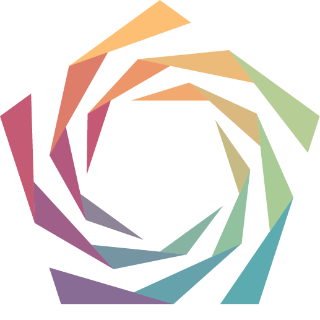

In [48]:
ds_client

Inspect available API endpoints with:

In [52]:
ds_client.custom_api.api_endpoints()

[syft.service.api.api.TwinAPIEndpointView,
 syft.service.api.api.TwinAPIEndpointView]

A data scientist can check whether an endpoint is intended to be public or whether it follows the mock/private paradigm, as well as the name of the underlying mock function and worker pool. The latter are rather informative.

Now, we can inpsect each endpoint even further:

In [56]:
ds_client.api.services.nimbusdb.query

## API: nimbusdb.query
### Description: <span style="font-weight: lighter;">Allows to query to NimbusDB, a fully managed SQL db in Nimbus.</span><br>
#### Private Code:
```python
N / A
```
#### Public Code:
```python
N / A
```


In [57]:
ds_client.api.services.nimbusdb.schema

## API: nimbusdb.schema
### Description: <span style="font-weight: lighter;">
    ## Description
    Allows to get the schema of a table to NimbusDB, a fully managed SQL db in Nimbus.
    
    ## Available tables
    - users
    - sessions
    - content
    - ...

    ## How to use
    Run `.api.services.nimbusdb.schema(table="users")`
    </span><br>
#### Private Code:
```python
N / A
```
#### Public Code:
```python
def get_schema(
    context,
    table: str,
):
    from external import NimbusDBClient
    import pandas as pd

    # Create a client instance
    client = NimbusDBClient(context.settings["key"], context.settings["endpoint"])

    # Connect to NimbusDB
    client.connect()

    # Execute the query
    result = client.get_schema(table=table)
    if not isinstance(result, pd.DataFrame):
        return SyftError(message=result)
    elif "Error: " in result:
        return SyftError(message="An error occured. Please check your query and contact the admin if it persists.")

    return pd.DataFrame(result)

```


Ideally, the description would contain enough information for us to understand the API format or link to external documentation hosted elsewhere. Let's test our endpoint against some mock/public queries.

In [61]:
# Use a public endpoint
ds_client.api.services.nimbusdb.schema(table="users")

Fetching table metadata: users


Pointer:
   field_name field_type
0          id        int
1  session_id        int
2        name        str
3         ...        ...

In [62]:
# Use the mock side of a private one
ds_client.api.services.nimbusdb.query(query="SELECT 1")

Executing query: SELECT 1


Pointer:
   id   name
0   1  Alice
1   2    Bob

The above defaults to the *mock* execution. Executing the private version is not allowed.

In [63]:
ds_client.api.services.nimbusdb.query.private(query="SELECT 1")

SyftError: You're not allowed to run this code.
SyftError: You're not allowed to run this code.
SyftError: You're not allowed to run this code.


SyftError: You're not allowed to run this code.

Now, if we cannot execute the private counterpart without approval, how should we get that approval from the data owner?

## |:data_owner:| 4. Data Scientist: Request approval while using a custom API endpoint

A data scientist can use an API endpoint just like any other asset, as part of the input policy of a syft function. 

A data scientist can easily use the `.mock` side of a dataset asset. However, to run any computation on the real asset, they need to create a `syft` function that shows how they intend to use it. Based on that function, the data owner can approve or deny the request, and the data scientists get permission to execute it or to fetch the result.

The same concept applies here.

In [64]:
@sy.syft_function_single_use(
    endpoint=ds_client.api.services.nimbusdb.query
)
def foo(endpoint):
    query = "SELECT 1"
    return endpoint(query=query)

SyftSuccess: Syft function 'foo' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [69]:
ds_client.code.request_code_execution(foo)

syft.service.request.request.Request

In [70]:
ds_client.code

## |:data_scientist:| 5. Data Owner: Approving the request

This is very similar to what we've already seen.

In [71]:
client.requests

In [72]:
client.requests[0].code

```python
@sy.syft_function_single_use(
    endpoint=ds_client.api.services.nimbusdb.query
)
def foo(endpoint):
    query = "SELECT 1"
    return endpoint(query=query)
```

We can see the code and check if it uses our API endpoint in a way that we agree. 

In [73]:
client.requests[0].approve()

Approving request on change foo for datasite test-datasite


SyftSuccess: Request d61ed95e50f944f5b9070e25419a10e8 changes applied

Now, a data scientist can fetch the result to their computation:

In [74]:
# Won't work on the private endpoint
ds_client.code.foo(endpoint=ds_client.api.services.nimbusdb.query)

Executing query: SELECT 1


Pointer:
   id   name
0   1  Alice
1   2    Bob

Success! Now you have seen how PySyft can facilitate responsible access to data hosted on external data warehouses or platforms.